In [1]:
import sys
sys.path.append("..")

import h5py
import numpy as np
from tqdm import tqdm
from pathlib import Path
from utils.plot_utils import *
import matplotlib.pyplot as plt
from astropy import units, constants
from scipy.interpolate import griddata
from scipy.stats import norm, binned_statistic_2d

In [2]:
from julia import Main

In [3]:
Main.eval("Threads.nthreads()")

10

## Velocity Broadening
The beamsource can be modelled as an extended source, spawning molecules in a 2D gaussian distribution with width $\sigma = 4.83 mm$ at 1 cm from the cell opening.  
From Oskari's beamsource characterization report the forward velocity is 184 m/s $\pm$ 16.8 m/s, width a transverse velocity $\sigma_\perp = 93/2\sqrt{2}\log{2}$ m/s.  

The Doppler shift in frequency is given by $f = f_0 \left(1+v/c\right)$, where $f_0$ is the rest frequency.

In [4]:
@units.quantity_input
def doppler_shift(v: units.m/units.s, frequency: units.Hz):
    return (frequency*(1+v/constants.c)).to(units.Hz)

In [5]:
Γ = (1/(100*units.ns)).to(units.Hz)
vp = 1*units.m/units.s
ω = (2*np.pi*constants.c/(271*units.nm)).to(units.Hz)

In [6]:
v_to_Γ = (doppler_shift(vp,ω) - ω)/Γ
print(f'1 m/s transverse velocity results in a frequency shift of {v_to_Γ:.2f} Γ')

1 m/s transverse velocity results in a frequency shift of 2.32 Γ


The rotational cooling detection scheme has 2 apertures with a radius of 4 mm, one placed before the rotational cooling chamber and another before the detection chamber.

Now spawning the molecules with random positions and velocities, drawn from gaussian distributions.

In [7]:
# from Oskari's Beam Characterization report
vcm = 184
vcm_sigma = 16.8
vt_sigma = 93/(2*np.sqrt(2*np.log(2))) # from FWHM

# coordinate width, adapted from ACME to CeNTREX based on email from Xing Wu on 6-10-2020
sigma_width = 0.25*25.4/5 * 3.8e-3

v_acceptable = 1.5 # m/s

v_laser = 1.5 # m/s, molecules the laser can interact with
r_laser = 5e-3 # m

In [8]:
generate_random_r = lambda x: np.random.normal(0,sigma_width,x)
generate_random_longitudinal_velocities = lambda x: np.random.normal(vcm, vcm_sigma, x)

def generate_random_coords(size):
    xy = np.empty([2,size])
    xy[0,:] = generate_random_r(size)
    xy[1,:] = generate_random_r(size)
    return xy
            
def generate_random_transverse_velocities(size):
    v_transverse = np.random.multivariate_normal([0,0],np.array([[vt_sigma**2,0],[0,vt_sigma**2]]),size).T
    return v_transverse

In [101]:
np.random.seed(42)
size = int(1e7)
coords = generate_random_coords(size)
v_z = generate_random_longitudinal_velocities(size)
v_x, v_y = generate_random_transverse_velocities(size)

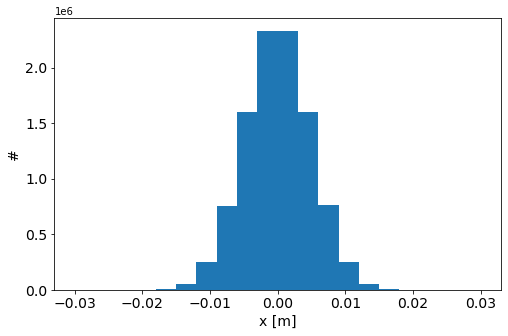

In [102]:
fig, ax = plt.subplots(figsize = (8,5))
ax.hist(coords[0,:], bins = np.linspace(-0.03, 0.03, 21))
ax.set_xlabel('x [m]')
ax.set_ylabel('#')

set_fontsize(ax, 14)

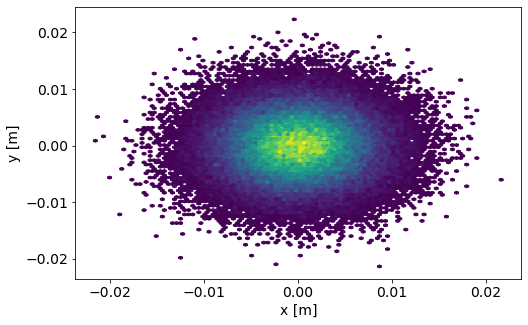

In [103]:
fig, ax = plt.subplots(figsize = (8,5))
ax.hexbin(coords[0,:][:int(1e5)],coords[1,:][:int(1e5)], mincnt = 1)
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')

set_fontsize(ax, 14)

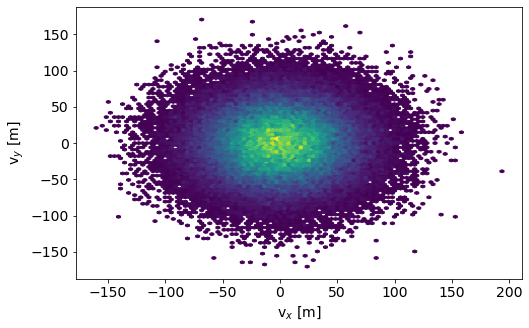

In [104]:
fig, ax = plt.subplots(figsize = (8,5))
ax.hexbin(v_x[:int(1e5)], v_y[:int(1e5)], mincnt = 1)
ax.set_xlabel(r'v$_x$ [m]')
ax.set_ylabel(r'v$_y$ [m]')

set_fontsize(ax, 14)

### Without Aperture
Without an aperture there are several transverse velocity limiting components in the beamline.  
The closest to the rotational cooling chamber is the entrance flange, where the 1st colimator would also be placed.
The distance from the assumed extended source of this component is 17.36" - 1 cm, and the opening diameter is 60 mm.

In [105]:
in_to_m = (units.imperial.inch).to(units.m)

In [106]:
distance_aperture_1 = 17.36 * in_to_m - 0.01

filtered = np.empty([3,size])

dt = distance_aperture_1/v_z
filtered[0,:] = coords[0,:]+dt*v_x
filtered[1,:] = coords[1,:]+dt*v_y
filtered[2,:] = distance_aperture_1

m = np.sqrt(np.sum(filtered[:2,:]**2, axis = 0)) < 60/2 * 1e-3
size = m.sum()

v_x_full, v_y_full, v_z_full = v_x.copy(), v_y.copy(), v_z.copy()
v_x, v_y, v_z = v_x[m], v_y[m], v_z[m]

coords_full = coords.copy()
coords = np.empty([2,size])
coords[0,:] = coords_full[0,:][m]
coords[1,:] = coords_full[1,:][m]

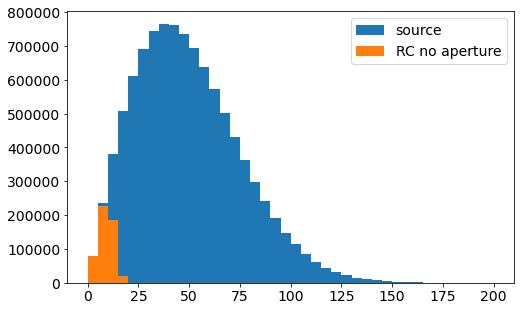

In [107]:
dx = 5
b = np.arange(0,200+dx,dx)

fig, ax = plt.subplots(figsize = (8,5))
ax.hist(np.sqrt(v_x_full**2+v_y_full**2), bins = b, label = 'source')
ax.hist(np.sqrt(v_x**2+v_y**2), bins = b, label = 'RC no aperture')
ax.legend(fontsize = 14)
set_fontsize(ax, 14)

distance to RC laser from cell opening is 21.75"  
distance to aperture #1 from cell opening is 17.36"  

distance to LIF laser from cell opening is 38.39"  
distance to aperture #2 from cel opening is 35.37" 

In [108]:
distance_aperture_1 = 17.36 * in_to_m - 0.01

coords_aperture_1 = np.empty([3,size])

dt = distance_aperture_1/v_z
coords_aperture_1[0,:] = coords[0,:]+dt*v_x
coords_aperture_1[1,:] = coords[1,:]+dt*v_y
coords_aperture_1[2,:] = distance_aperture_1

In [109]:
distance_aperture_2 = 31 * in_to_m - 0.01

coords_aperture_2 = np.empty([3,size])

dt = distance_aperture_2/v_z
coords_aperture_2[0,:] = coords[0,:]+dt*v_x
coords_aperture_2[1,:] = coords[1,:]+dt*v_y
coords_aperture_2[2,:] = distance_aperture_2

In [110]:
distance_laser_rc = 21.75 * in_to_m - 0.01
dt = distance_laser_rc/v_z

m_interaction_rc = (np.abs(coords[1,:]+dt*v_y) <= r_laser) & (np.abs(v_x) <= v_laser)
interaction_rc = np.sum(m_interaction_rc)

In [111]:
distance_laser_lif = 38.30 * in_to_m - 0.01
dt = distance_laser_lif/v_z

m_iteraction_lif = (np.abs(coords[1,:]+dt*v_y) <= r_laser) & (np.abs(v_x) <= v_laser)
interaction_lif = np.sum(m_iteraction_lif)

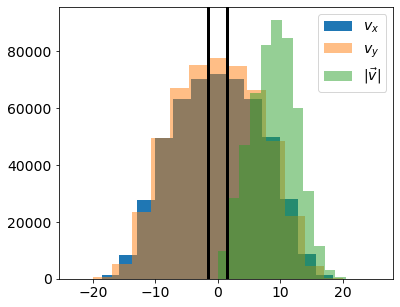

In [112]:
fig, ax = plt.subplots(figsize = (6,5))

bins = 15

ax.hist(v_x, bins = bins, label = r'$v_x$')
ax.hist(v_y, bins = bins, alpha = 0.5, label = r'$v_y$')
ax.hist(np.sqrt(v_x**2+v_y**2), bins = bins, alpha = 0.5, label = r'$|\vec{v}|$')

ax.legend(fontsize = 14)

ax.axvline(v_acceptable, lw = 3, color = 'k')
ax.axvline(-v_acceptable, lw = 3, color = 'k')
set_fontsize(ax, 14)

This figure shows the transverse velocity spread in the rotational cooling chamber.

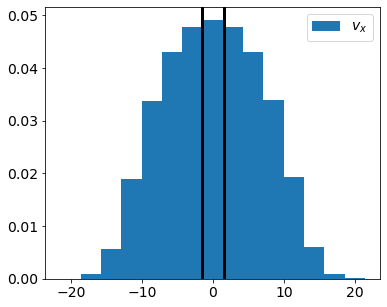

In [113]:
fig, ax = plt.subplots(figsize = (6,5))

bins = 15

ax.hist(v_x, bins = bins, label = r'$v_x$', density=True)

ax.legend(fontsize = 14)

ax.axvline(v_acceptable, lw = 3, color = 'k')
ax.axvline(-v_acceptable, lw = 3, color = 'k')
set_fontsize(ax, 14)

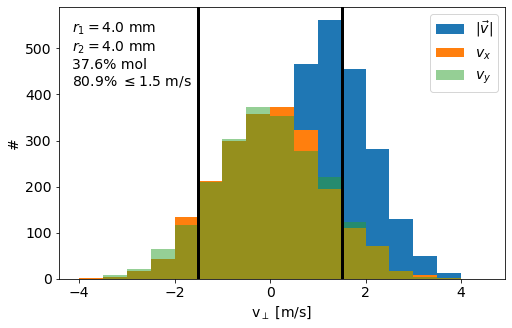

In [142]:
# calculating the velocity spread after 2 apertures
# both with an aperture radius of 4 mm

r1 = 4e-3
r2 = 4e-3

bins = np.arange(-4,4+1,0.5)

fig, ax = plt.subplots(figsize = (8,5))

m1 = np.sqrt(np.sum(coords_aperture_1[:2]**2, axis = 0)) <= r1
m2 = np.sqrt(np.sum(coords_aperture_2[:2]**2, axis = 0)) <= r2
m  = m1 & m2

ax.hist(np.sqrt(v_x[m]**2+v_y[m]**2), bins = bins, label = r'$|\vec{v}|$')
ax.hist(v_x[m], bins = bins, label = r'$v_x$')
ax.hist(v_y[m], bins = bins, alpha = 0.5, label = r'$v_y$')

ax.legend(fontsize = 14, loc = 1)

ax.axvline(v_acceptable, lw = 3, color = 'k')
ax.axvline(-v_acceptable, lw = 3, color = 'k')

ax.set_xlabel(r'v$_\perp$ [m/s]')
ax.set_ylabel('#')

set_fontsize(ax, 14)
    
dt = distance_laser_lif/v_z[m]
m_interact = (np.abs(coords[1,:][m]+dt*v_y[m]) <= r_laser) & (np.abs(v_x[m]) <= v_laser)
interact = m_interact.sum()/interaction_lif*100

text = f'$r_1 = ${r1*1e3:.1f} mm'+'\n'
text += f'$r_2 = ${r2*1e3:.1f} mm'+'\n'
text += f'{m.sum()/interaction_lif*100:.1f}% mol'+'\n'
text += f'{(100*(np.abs(v_x[m]) < 1.5).sum()/m.sum()):.1f}% $\leq {v_acceptable}$ m/s'
ax.text(0.03, 0.95, text, transform = ax.transAxes,
        ha = 'left', va = 'top', fontsize = 14);

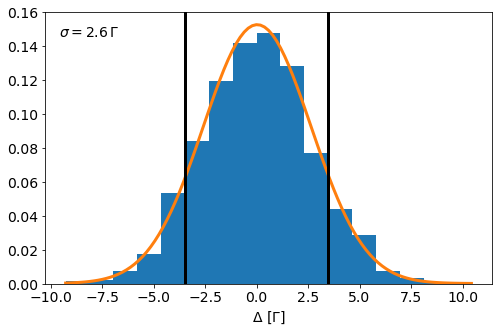

In [115]:
bins = np.arange(-4*v_to_Γ,(4+1)*v_to_Γ,0.5*v_to_Γ)

fig, ax = plt.subplots(figsize = (8,5))

m1 = np.sqrt(np.sum(coords_aperture_1[:2]**2, axis = 0)) <= r1
m2 = np.sqrt(np.sum(coords_aperture_2[:2]**2, axis = 0)) <= r2
m  = m1 & m2

mask_filtered_beam = m.copy()

ax.hist(v_x[m]*v_to_Γ, bins = bins, label = r'$v_x$', density = True)

mu, sigma = norm.fit(v_x[m]*v_to_Γ)

_x = np.linspace(bins.min(), bins.max(), 101)
ax.plot(_x, norm.pdf(_x, mu, sigma), lw = 3)

ax.axvline(v_acceptable*v_to_Γ, lw = 3, color = 'k')
ax.axvline(-v_acceptable*v_to_Γ, lw = 3, color = 'k')

ax.set_xlabel(r'$\Delta$ [Γ]')
set_fontsize(ax, 14)

text = f'$\sigma = ${sigma:.1f}$\,$Γ'
ax.text(0.03, 0.95, text, transform = ax.transAxes,
        ha = 'left', va = 'top', fontsize = 14);

The transverse velocity spread that makes it to the LIF detection region in units of $\Gamma$.

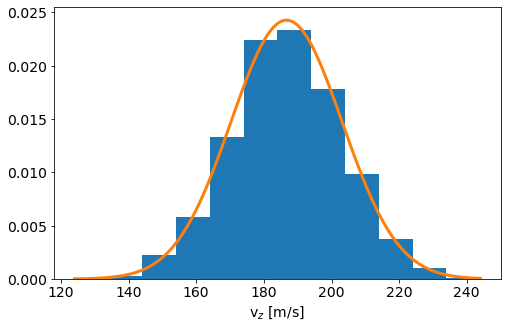

In [116]:
bins = np.linspace(184-60, 184+60, 13)

fig, ax = plt.subplots(figsize = (8,5))
ax.hist(v_z[m], density = True, bins = bins)


mu_z, sigma_z = norm.fit(v_z[m])

_z = np.linspace(bins.min(), bins.max(), 101)
ax.plot(_z, norm.pdf(_z, mu_z, sigma_z), lw = 3)


ax.set_xlabel(r'v$_z$ [m/s]')
set_fontsize(ax, 14)

longitudinal velocity spread that makes it to the LIF chamber

# Light Multipass
The multipass spans about 1.25".  
The cylindrically expanded beam is expanded to $5265~\mu$m ($4\sigma$) in height, and $2642~\mu$m ($4\sigma$) in width.

In [25]:
def gaussian(x, μ, σ):
    return np.exp(-(x-μ)**2 / (2 * σ**2))

In [26]:
def gaussian_amp(x, a, μ, σ):
    return a*np.exp(-(x-μ)**2 / (2 * σ**2))

In [27]:
def multipass_prism_order(passes):
    npass = [1]
    for p in range(1,passes):
        if p%2 == 0:
            npass.append(p+1)
        else:
            npass.append(passes-p)
    return npass

In [28]:
nr_passes = 15
beam_spacing = (1.75*units.imperial.inch).to(units.m)/nr_passes
beam_locs = np.array([i*beam_spacing.value for i in range(nr_passes)]) + 0.005

In [29]:
# make height 2x bigger than previous run
σzlaser = 2642*1e-6/4 # σ width of the laser.
σylaser = 2*5265*1e-6/4 # σ height of the laser

In [30]:
_z = np.linspace(0,beam_locs.max()+2*beam_spacing.value,501)

In [31]:
reflections = (np.array(multipass_prism_order(15))-1)
loss = 0.04 # reflection loss per pass
amplitudes = np.array([(1-loss)**r for r in reflections])

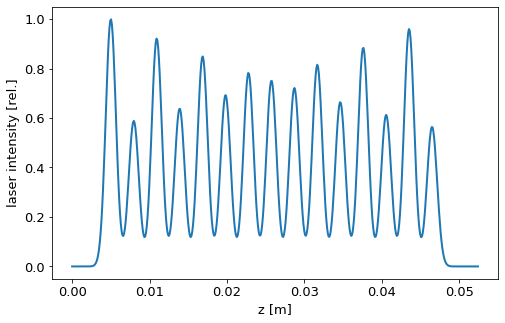

In [32]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(_z, gaussian_amp(_z[:,np.newaxis], amplitudes[np.newaxis, :], beam_locs[np.newaxis, :], σzlaser).sum(axis = 1), lw = 2)

ax.set_xlabel('z [m]')
ax.set_ylabel('laser intensity [rel.]')

set_fontsize(ax, 13)

In [33]:
def gaussian_2d(y,z,μy,μz,σy,σz):
    a = (y-μy)**2/(2*σy**2)
    b = (z-μz)**2/(2*σz**2)
    return np.exp(-(a+b))

In [34]:
def gaussian_2d_amp(a,y,z,μy,μz,σy,σz):
    return a*gaussian_2d(y,z,μy,μz,σy,σz)

In [35]:
yi = np.linspace(-5,5,201)*σylaser
zi = np.linspace(0,0.05,1001)
Y,Z = np.meshgrid(yi,zi)

In [36]:
gaussian_amp(_z[:,np.newaxis], amplitudes[np.newaxis, :], beam_locs[np.newaxis, :], σzlaser).sum(axis = 1).shape

(501,)

<ipython-input-37-9ca129b83bef>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(Z.T*1e3,Y.T*1e3,intensity_multipass.T)


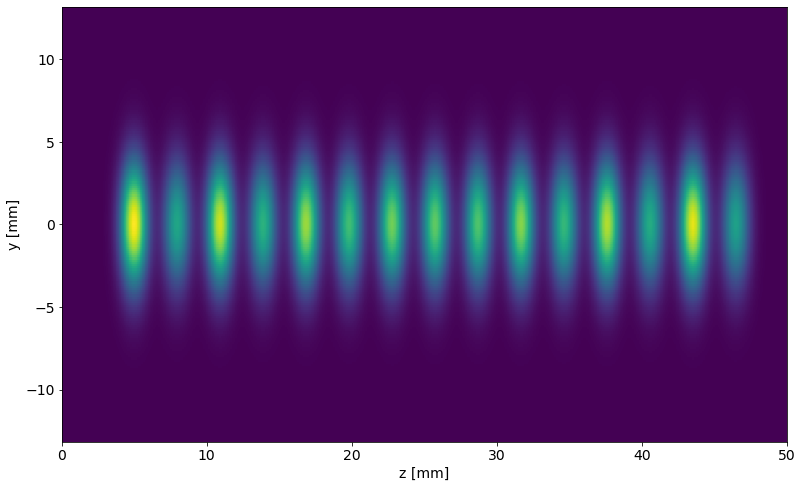

In [37]:
intensity_multipass = gaussian_2d_amp(amplitudes[np.newaxis,:], 
                                      Y[:,:,np.newaxis], Z[:,:,np.newaxis], 
                                      0,  beam_locs[np.newaxis, :], 
                                      σylaser, σzlaser).sum(axis = 2)

fig, ax = plt.subplots(figsize = (13,8))
ax.pcolormesh(Z.T*1e3,Y.T*1e3,intensity_multipass.T)

ax.set_xlabel('z [mm]')
ax.set_ylabel('y [mm]')

set_fontsize(ax, 14)

## Running in Julia

In [38]:
Main.eval("""using Waveforms""")
Main.eval("""using DifferentialEquations""")
Main.eval("""using BenchmarkTools""")
Main.eval("""
using Logging: global_logger
using TerminalLoggers: TerminalLogger
global_logger(TerminalLogger())
""")

<PyCall.jlwrap Logging.ConsoleLogger(Base.TTY(Base.Libc.WindowsRawSocket(0x0000000000000700) open, 0 bytes waiting), Info, Logging.default_metafmt, true, 0, Dict{Any,Int64}())>

In [39]:
Main.eval("""
function square_wave(t::Float64, frequency::Float64, phase::Float64)
    0.5.*(1 .+ squarewave(2*pi.*frequency.*t .+ phase))
end
""")

<PyCall.jlwrap square_wave>

In [40]:
Main.eval("""
function gaussian_2d(x::Float64, y::Float64, a::Float64, μx::Float64, μy::Float64, σx::Float64, σy::Float64)::Float64
    a.*exp(.- ((x.-μx).^2 ./ (2 .* σx.*σx) + (y.-μy).^2 ./ (2 .* σy.*σy)))
end
""")

<PyCall.jlwrap gaussian_2d>

In [41]:
# assuming the laser beam is centered, e.g. μy = 0
Main.eval("""
function multipass_2d_intensity(x::Float64, y::Float64, amplitudes, locations, σx::Float64, σy::Float64)::Float64
    intensity::Float64 = 0.0
    for i = 1:length(amplitudes)
        @inbounds intensity += gaussian_2d(x,y,amplitudes[i],locations[i],0.0, σx,σy)
    end
    return intensity
end
""")

<PyCall.jlwrap multipass_2d_intensity>

In [42]:
Main.amplitudes = amplitudes
Main.beam_locs = beam_locs
Main.σylaser = σylaser
Main.σzlaser = σzlaser
Main.σymu = 0.0254/2
Main.σzmu = 0.0254/2
Main.muy = 0.
Main.muz = 0.0257

In [43]:
Main.eval("typeof(Main.beam_locs)")

<PyCall.jlwrap Array{Float64,1}>

In [44]:
Main.eval("""
@time multipass_2d_intensity(0.04,0.,amplitudes,beam_locs,σzlaser, σylaser)
""")

0.42890221590688876

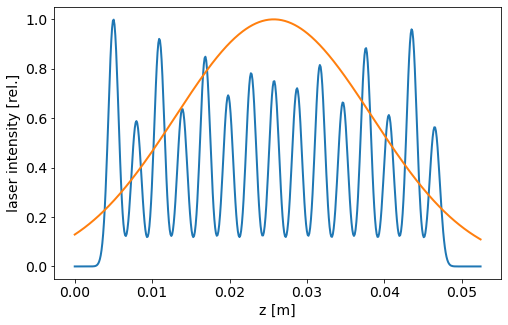

In [45]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(_z, [Main.multipass_2d_intensity(zi, 0., amplitudes, beam_locs, σzlaser, σzlaser) for zi in _z], lw = 2)
ax.plot(_z, [Main.gaussian_2d(zi, 0., 1., Main.muz, Main.muy, Main.σzmu, Main.σymu) for zi in _z], lw = 2)

ax.set_xlabel('z [m]')
ax.set_ylabel('laser intensity [rel.]')

set_fontsize(ax, 14)

In [46]:
# reading from file
with open('../ode_fun_mu1mu2.jl', 'r', encoding='utf8') as f:
    ode_fun = f.read()

In [47]:
for l in ode_fun.split('\n')[:20]:
    print(l)


function Lindblad_rhs!(du, ρ, p, t)
	@inbounds begin
		Ω = p[1]
		Ωᶜ = conj(Ω)
		νp = p[2]
		Ω1 = p[3]
		Ω1ᶜ = conj(Ω1)
		νp1 = p[4]
		Ω2 = p[5]
		νp2 = p[6]
		Ω2ᶜ = conj(Ω2)
		Δ = p[7]
		Plx = square_wave(t, νp, 3.141592653589793)
		Plz = square_wave(t, νp, 0.0)    
		Pm1y = square_wave(t, νp1, 1.0471975511965976)
		Pm1z = square_wave(t, νp1, 4.1887902047863905)
		Pm2y = square_wave(t, νp2, 2.0943951023931953)
		Pm2z = square_wave(t, νp2, 5.235987755982988)
		du[1,1] = 3367347.38920463*ρ[65,65] + 3367525.85757618*ρ[66,66] + 3367704.32982945*ρ[67,67]


In [48]:
ode_fun_new = """
function Lindblad_rhs!(du, ρ, p, t)
\t@inbounds begin
\t\tνp = p[2]
\t\tΔ = p[3]
\t\tvz = p[4]
\t\tvy = p[5]
\t\ty0 = p[6]
\t\tσzlaser = p[7]
\t\tσylaser = p[8]
\t\tn_passes = floor(Int8,p[9])
\t\tνp1 = p[10]
\t\tzmu1 = p[11]
\t\tymu1 = p[12]
\t\tσzmu1 = p[13]
\t\tσymu1 = p[14]
\t\tΩ1 = p[15].*gaussian_2d(vz*t, y0+vy*t, 1., zmu1, ymu1, σzmu1, σymu1)
\t\tΩ1ᶜ = conj(Ω1)
\t\tνp2 = p[16]
\t\tzmu2 = p[17]
\t\tymu2 = p[18]
\t\tσzmu2 = p[19]
\t\tσymu2 = p[20]
\t\tΩ2 = p[21].*gaussian_2d(vz*t, y0+vy*t, 1., zmu2, ymu2, σzmu2, σymu2)
\t\tΩ2ᶜ = conj(Ω2)
\t\tΩ = p[1]*multipass_2d_intensity(vz*t, y0+vy*t, p[21:21+n_passes], p[21+n_passes:end], σzlaser, σylaser)
\t\tΩᶜ = conj(Ω)
\t\tPlx = square_wave(t, νp, 3.141592653589793)
\t\tPlz = square_wave(t, νp, 0.0)  
\t\tPm1y = square_wave(t, νp1, 1.0471975511965976)
\t\tPm1z = square_wave(t, νp1, 4.1887902047863905)  
\t\tPm2y = square_wave(t, νp2, 2.0943951023931953)
\t\tPm2z = square_wave(t, νp2, 5.235987755982988)  
"""

In [49]:
ode_fun_new += '\n'.join(ode_fun.split('\n')[19:])
for l in ode_fun_new.split('\n')[:40]:
    print(l)


function Lindblad_rhs!(du, ρ, p, t)
	@inbounds begin
		νp = p[2]
		Δ = p[3]
		vz = p[4]
		vy = p[5]
		y0 = p[6]
		σzlaser = p[7]
		σylaser = p[8]
		n_passes = floor(Int8,p[9])
		νp1 = p[10]
		zmu1 = p[11]
		ymu1 = p[12]
		σzmu1 = p[13]
		σymu1 = p[14]
		Ω1 = p[15].*gaussian_2d(vz*t, y0+vy*t, 1., zmu1, ymu1, σzmu1, σymu1)
		Ω1ᶜ = conj(Ω1)
		νp2 = p[16]
		zmu2 = p[17]
		ymu2 = p[18]
		σzmu2 = p[19]
		σymu2 = p[20]
		Ω2 = p[21].*gaussian_2d(vz*t, y0+vy*t, 1., zmu2, ymu2, σzmu2, σymu2)
		Ω2ᶜ = conj(Ω2)
		Ω = p[1]*multipass_2d_intensity(vz*t, y0+vy*t, p[21:21+n_passes], p[21+n_passes:end], σzlaser, σylaser)
		Ωᶜ = conj(Ω)
		Plx = square_wave(t, νp, 3.141592653589793)
		Plz = square_wave(t, νp, 0.0)  
		Pm1y = square_wave(t, νp1, 1.0471975511965976)
		Pm1z = square_wave(t, νp1, 4.1887902047863905)  
		Pm2y = square_wave(t, νp2, 2.0943951023931953)
		Pm2z = square_wave(t, νp2, 5.235987755982988)  
		du[1,1] = 3367347.38920463*ρ[65,65] + 3367525.85757618*ρ[66,66] + 3367704.32982945*ρ[67,67]
	

In [50]:
# defining the function in Julia
# make function smaller for testing purposes
# ode_fun_new = '\n'.join(ode_fun.split('\n')[1:300])
# ode_fun_new += '\n \t end \n \t nothing \n end'
Main.eval(ode_fun_new)

<PyCall.jlwrap Lindblad_rhs!>

### Generate density matrix

In [51]:
import scipy.constants as cst

def population(J, T, B=6.66733e9, n = 100):
    c = 2*np.pi*cst.hbar*B/(cst.k*T)
    g = lambda J: 4*(2*J+1)
    a = lambda J: -c*J*(J+1)
    Z = np.sum([g(i)*np.exp(a(i)) for i in range(n)])
    return g(J)*np.exp(a(J))/Z

In [52]:
def J_levels(J):
    return 4*(2*J + 1)

def J_slice(J):
    if J == 0:
        return np.s_[0:J_levels(0)]
    else:
        levels = J_levels(np.arange(J+1))
        return np.s_[np.sum(levels[:-1]):np.sum(levels)]

In [53]:
T = 6.3
ρ_ini = np.zeros([67,67], dtype = 'complex')

for J in range(0,4):
    p = population(J, T)
    levels = J_levels(J)
    sl = J_slice(J)
    np.fill_diagonal(ρ_ini[sl, sl], p/levels)

ρ_ini /= np.diag(ρ_ini).sum()

In [54]:
de_main = -0.39444661382277774 # main dipole transition moment
Γ = 1/(100e-9)
Ω =  1*Γ #*abs(de_main)
ωp = Γ
νp = ωp/(2*np.pi)
# νp = .25*Γ/(2*np.pi)
νp1 = νp
νp2 = νp
Δ = -0*Γ
Ω1 = 1*Γ
Ω2 = 1*Γ

Main.Ω = Ω
Main.νp = νp
Main.Δ = Δ
Main.Γ = Γ
Main.Ω1 = Ω1
Main.νp1 = νp1
Main.Ω2 = Ω2
Main.νp2 = νp2

Main.ρ_ini = ρ_ini
Main.vz = 180.
Main.vy = 0.

Main.n_passes = len(amplitudes)
Main.eval("p = [Ω, νp, Δ, vz, vy, 0., σzlaser, σylaser, n_passes, νp1, muz, muy, σzmu, σymu, Ω1, νp2, muz, muy, σzmu, σymu, Ω2]")
Main.eval("append!(p, amplitudes)")
Main.eval("append!(p, beam_locs)")

array([1.00000000e+07, 1.59154943e+06, 0.00000000e+00, 1.80000000e+02,
       0.00000000e+00, 0.00000000e+00, 6.60500000e-04, 2.63250000e-03,
       1.50000000e+01, 1.59154943e+06, 2.57000000e-02, 0.00000000e+00,
       1.27000000e-02, 1.27000000e-02, 1.00000000e+07, 1.59154943e+06,
       2.57000000e-02, 0.00000000e+00, 1.27000000e-02, 1.27000000e-02,
       1.00000000e+07, 1.00000000e+00, 5.88201367e-01, 9.21600000e-01,
       6.38239331e-01, 8.49346560e-01, 6.92533996e-01, 7.82757790e-01,
       7.51447478e-01, 7.21389579e-01, 8.15372698e-01, 6.64832636e-01,
       8.84736000e-01, 6.12709757e-01, 9.60000000e-01, 5.64673312e-01,
       5.00000000e-03, 7.96333333e-03, 1.09266667e-02, 1.38900000e-02,
       1.68533333e-02, 1.98166667e-02, 2.27800000e-02, 2.57433333e-02,
       2.87066667e-02, 3.16700000e-02, 3.46333333e-02, 3.75966667e-02,
       4.05600000e-02, 4.35233333e-02, 4.64866667e-02])

In [55]:
Main.eval("""
tmp = zeros(ComplexF64,67,67)
Lindblad_rhs!(tmp, ρ_ini, p, 1e-6)
@btime Lindblad_rhs!(tmp, ρ_ini, p, 1e-6)
tmp = 0
""")

0

## Single pass first
Setup a callback to stop solver when it reaches a certain position, in this case the end of the multi pass

In [56]:
Main.eval("""
condition(u,t,integrator) = integrator.p[4]*t > 0.05
affect!(integrator) = terminate!(
integrator)
cb = DiscreteCallback(condition, affect!)
""")

<PyCall.jlwrap DiscreteCallback{typeof(condition),typeof(affect!),typeof(DiffEqBase.INITIALIZE_DEFAULT)}(condition, affect!, DiffEqBase.INITIALIZE_DEFAULT, Bool[1, 1])>

In [57]:
Main.eval("""
tspan = (0.0f0, 500e-6)
prob = ODEProblem(Lindblad_rhs!,ρ_ini,tspan,p)
tmp = 0
""")

0

In [58]:
%%time
Main.eval("""
@time sol = solve(prob,Tsit5(),callback=cb, dt = 1e-9, adaptive=true,
            abstol = 2.5e-7, reltol = 2.5e-4)
tmp = 0
""")

Wall time: 25.5 s


0

In [59]:
v = Main.vz

ut = np.array(Main.eval("sol[:]")).T
pop_results = np.real(np.einsum('jji->ji',ut.reshape((ρ_ini.shape[0], ρ_ini.shape[1], ut.shape[2]))))
t_array = Main.eval("""sol.t""").copy()

t_array

#Plot populations in different J
P0_triplet = np.sum(pop_results[1:4,:], axis = 0)
P0_singlet = np.sum(pop_results[0:1,:], axis = 0)
P0 = np.sum(pop_results[:4], axis = 0)
P1 = np.sum(pop_results[4:16,:], axis = 0)
P2 = np.sum(pop_results[16:36,:], axis = 0)
P3 = np.sum(pop_results[36:64,:], axis = 0)
PB1 = np.sum(pop_results[64:,:], axis = 0)

J=0 ratio : 10.28


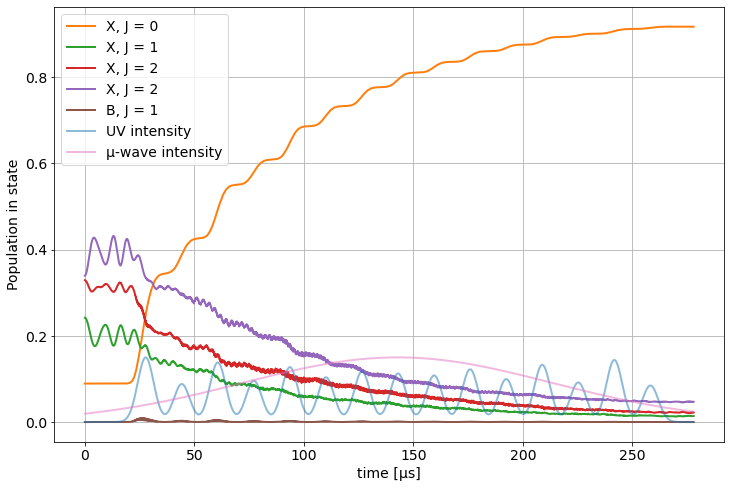

In [60]:
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(t_array*1e6, P0, label = 'X, J = 0', lw = 2, color = 'C1')
ax.plot(t_array*1e6, P1, label = 'X, J = 1', lw = 2, color = 'C2')
ax.plot(t_array*1e6, P2, label = 'X, J = 2', lw = 2, color = 'C3')
ax.plot(t_array*1e6, P3, label = 'X, J = 2', lw = 2, color = 'C4')
ax.plot(t_array*1e6, PB1, label = 'B, J = 1', lw = 2, color = 'C5')


ax.plot(t_array*1e6, [0.15*Main.multipass_2d_intensity(Main.vz*ti, Main.vy*ti, amplitudes, beam_locs, σzlaser, σzlaser) for ti in t_array], 
        lw = 2, color = 'C0', alpha = 0.5, label = 'UV intensity')
ax.plot(t_array*1e6, [0.15*Main.gaussian_2d(Main.vz*ti, Main.vy*ti, 1., Main.muz, Main.muy, Main.σzmu, Main.σymu) for ti in t_array], 
        lw = 2, color = 'C6', alpha = 0.5, label = 'μ-wave intensity')

ax.legend(fontsize = 14)
ax.set_xlabel('time [μs]', fontsize = 14)
ax.set_ylabel("Population in state", fontsize = 14)
ax.tick_params(axis='both', labelsize=14)
ax.grid(True)

print(f'J=0 ratio : {P0[-1]/np.diag(ρ_ini)[:4].sum().real:.2f}')

## Defining a parameter sweep of Ω, Ω1, Γ and $v_z$, $v_y$ from the distribution
$v_z$, $v_x$, $v_y$ and $y_0$ are coupled from the extended beamsource calculation

In [117]:
# multipass length ~ 1.5"
distance_laser_rc = (21.75-0.75) * in_to_m - 0.01
dt = distance_laser_rc/v_z

y0 = (coords[1,:]+dt*v_y)[mask_filtered_beam]

In [120]:
trajectories = 2000
Main.eval("Omegas = (Ω)*(1:1:2)")
Main.eval("Omegas1 = (Ω1)*(0.5:0.5:1.5)")
Main.eval("Omegas2 = (Ω2)*(0.5:0.5:1.5)")
Main.Deltas = v_x[mask_filtered_beam][:trajectories]*v_to_Γ*Γ
Main.vzs = v_z[mask_filtered_beam][:trajectories]
Main.vys = v_y[mask_filtered_beam][:trajectories]
Main.y0s = y0[:trajectories]

In [122]:
params = np.array(np.meshgrid(Main.Omegas, Main.Omegas1, Main.Omegas2)).T.reshape(-1,3)
_ = np.empty([params.shape[0]*trajectories,7])
_[:,:3] = np.repeat(params, trajectories, axis = 0)
_[:,3:] = np.tile(np.array([Main.Deltas, Main.vzs, Main.vys, Main.y0s]), len(Main.Omegas)*len(Main.Omegas1)*len(Main.Omegas2)).T
params = _
Main.param = params
print(params.shape)

(36000, 7)


In [123]:
# defining a progress bar to keep track of the ODE ensemble solver progress
Main.eval("using ProgressMeter")
Main.eval('const pbar = Progress(50, 1, "ODE Solving ", 50)')

<PyCall.jlwrap Progress(50, ReentrantLock(nothing, Base.GenericCondition{Base.Threads.SpinLock}(Base.InvasiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), 0), 1.0, 0, 1.617042000663e9, 1.617042000663e9, false, "ODE Solving ", 50, BarGlyphs('|', '█', '█', ' ', '|'), :green, Base.TTY(Base.Libc.WindowsRawSocket(0x0000000000000700) open, 0 bytes waiting), 0, 0, 0)>

In [124]:
# function called every time on the when an ODE solve is ready
# only save the diagonal of each solution (e.g. populations in each state)
Main.eval("""
function output_func(sol,i)
    next!(pbar)
    return [real(sol.u[end][j,j]) for j in 1:size(sol.u[end])[1]], false
end""")

<PyCall.jlwrap output_func>

In [125]:
# defining the function that changes the ODE parameters for each iteration
Main.eval("""
function prob_func(prob,i,repeat)
    remake(prob,p=[param[i,1]; νp; param[i,4]; param[i,5]; param[i,6]; param[i,7]; σzlaser; σylaser; n_passes; νp1; muz; muy; σzmu; σymu; param[i,2]; νp2; muz; muy; σzmu; σymu; param[i,3]; amplitudes; beam_locs])
end
""")

<PyCall.jlwrap prob_func>

In [126]:
# setting up the EnsembleProblem with the earlier defined ODEProblem
Main.eval("""
ens_prob = EnsembleProblem(prob, prob_func = prob_func, output_func = output_func)
""")

<PyCall.jlwrap EnsembleProblem with problem ODEProblem>

In [127]:
# making sure multiple threads are enabled
Main.eval("Threads.nthreads()")

10

In [128]:
# starting the parallel ensemble simulation
# precision of the solver is increased resulting in a longer runtime
# probably not necessary
Main.eval("pbar.counter = 0")
Main.eval("pbar.n = size(param)[1]")
Main.eval("""
@time sim = solve(ens_prob, Tsit5(), EnsembleThreads(), save_start = true, save_end = true, 
            save_everystep = false; trajectories = trajectories = size(param)[1], dt = 1e-9, adaptive=true,
            abstol = 5e-7, reltol = 5e-4, callback = cb)
sim.elapsedTime
""")

101616.612492

In [129]:
ens_u = Main.eval("sim.u")
ens_u = np.array(ens_u)

In [130]:
# putting the results into a single numpy array
results_array = np.zeros([len(ens_u),7+67])

for idx, ((Ω_factor, Ω1_factor, Ω2_factor, Δ_factor, vz_factor, vy_factor, y0_factor), ut_ens) in tqdm(enumerate(zip(Main.param,ens_u)), total = len(ens_u)):
    results_array[idx,:] = [Ω_factor, Ω1_factor, Ω2_factor, Δ_factor, vz_factor, vy_factor, y0_factor] + list(ut_ens)

100%|█████████████████████████████████████████████████████████████████████████| 36000/36000 [00:00<00:00, 54723.18it/s]


In [131]:
fname = 'laser_mu1mu2_rc_pol_switching_on_apertures_2020_10_28_2x_beamheight'
np.save(fname, results_array)

In [132]:
fname = 'laser_mu1mu2_rc_pol_switching_on_apertures_2020_10_28_2x_beamheight'
results_array = np.load(fname+'.npy')

In [133]:
# for making Ω slices I round Ω_factor to two digits to preven any floating point issues
# keep in mind when the desired spacing is less than two digits to remove rounding or 
# increase the digits
results_array_J0 = np.zeros([len(results_array),8])
for idx, (Ω_factor, Ω1_factor, Ω2_factor, Δ_factor, vz_factor, vy_factor, y0_factor, *pops) in tqdm(enumerate(results_array), total = len(results_array)):
    results_array_J0[idx,:] = [round(Ω_factor/Γ,2), Ω1_factor, Ω2_factor, Δ_factor/Γ, vz_factor, vy_factor, y0_factor, np.sum(pops[:4])]

100%|█████████████████████████████████████████████████████████████████████████| 36000/36000 [00:00<00:00, 41551.01it/s]


In [137]:
P0_ini = np.diag(ρ_ini[:4,:4]).sum().real

for Ω_factor in np.unique(results_array_J0[:,0]):
    for Ω1_factor in np.unique(results_array_J0[:,1]):
        for Ω2_factor in np.unique(results_array_J0[:,2]):
            m = results_array_J0[:,0] == Ω_factor
            m1 = results_array_J0[:,1] == Ω1_factor
            m2 = results_array_J0[:,2] == Ω2_factor
            m = m & m1 & m2
            mean_population = np.mean(results_array_J0[m][:,-1])/P0_ini
            mean_err_population = np.std(results_array_J0[m][:,-1]/P0_ini)/np.sqrt(trajectories)
            print(f'Ω : {Ω_factor:.1f}Γ; Ω1 : {Ω1_factor/Γ:.1f}Γ; Ω2 : {Ω2_factor/Γ:.1f}Γ  -> ratio = {mean_population:.3f} +/- {mean_err_population:.3f}')

Ω : 1.0Γ; Ω1 : 0.5Γ; Ω2 : 0.5Γ  -> ratio = 5.992 +/- 0.051
Ω : 1.0Γ; Ω1 : 0.5Γ; Ω2 : 1.0Γ  -> ratio = 6.209 +/- 0.055
Ω : 1.0Γ; Ω1 : 0.5Γ; Ω2 : 1.5Γ  -> ratio = 6.527 +/- 0.058
Ω : 1.0Γ; Ω1 : 1.0Γ; Ω2 : 0.5Γ  -> ratio = 6.295 +/- 0.054
Ω : 1.0Γ; Ω1 : 1.0Γ; Ω2 : 1.0Γ  -> ratio = 6.565 +/- 0.058
Ω : 1.0Γ; Ω1 : 1.0Γ; Ω2 : 1.5Γ  -> ratio = 6.763 +/- 0.060
Ω : 1.0Γ; Ω1 : 1.5Γ; Ω2 : 0.5Γ  -> ratio = 6.550 +/- 0.057
Ω : 1.0Γ; Ω1 : 1.5Γ; Ω2 : 1.0Γ  -> ratio = 6.812 +/- 0.060
Ω : 1.0Γ; Ω1 : 1.5Γ; Ω2 : 1.5Γ  -> ratio = 7.110 +/- 0.063
Ω : 2.0Γ; Ω1 : 0.5Γ; Ω2 : 0.5Γ  -> ratio = 8.184 +/- 0.041
Ω : 2.0Γ; Ω1 : 0.5Γ; Ω2 : 1.0Γ  -> ratio = 8.603 +/- 0.045
Ω : 2.0Γ; Ω1 : 0.5Γ; Ω2 : 1.5Γ  -> ratio = 9.024 +/- 0.047
Ω : 2.0Γ; Ω1 : 1.0Γ; Ω2 : 0.5Γ  -> ratio = 8.635 +/- 0.043
Ω : 2.0Γ; Ω1 : 1.0Γ; Ω2 : 1.0Γ  -> ratio = 9.034 +/- 0.046
Ω : 2.0Γ; Ω1 : 1.0Γ; Ω2 : 1.5Γ  -> ratio = 9.271 +/- 0.046
Ω : 2.0Γ; Ω1 : 1.5Γ; Ω2 : 0.5Γ  -> ratio = 8.994 +/- 0.045
Ω : 2.0Γ; Ω1 : 1.5Γ; Ω2 : 1.0Γ  -> ratio = 9.324 +/- 0.0

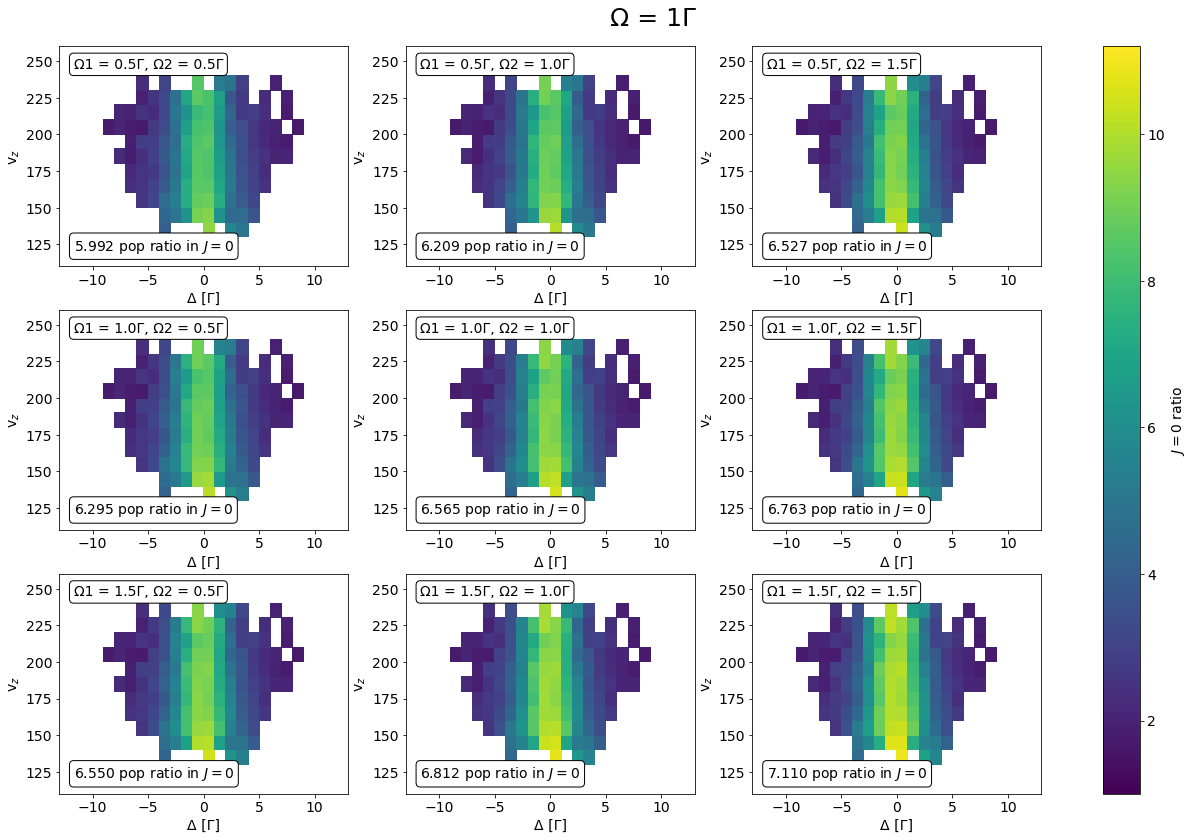

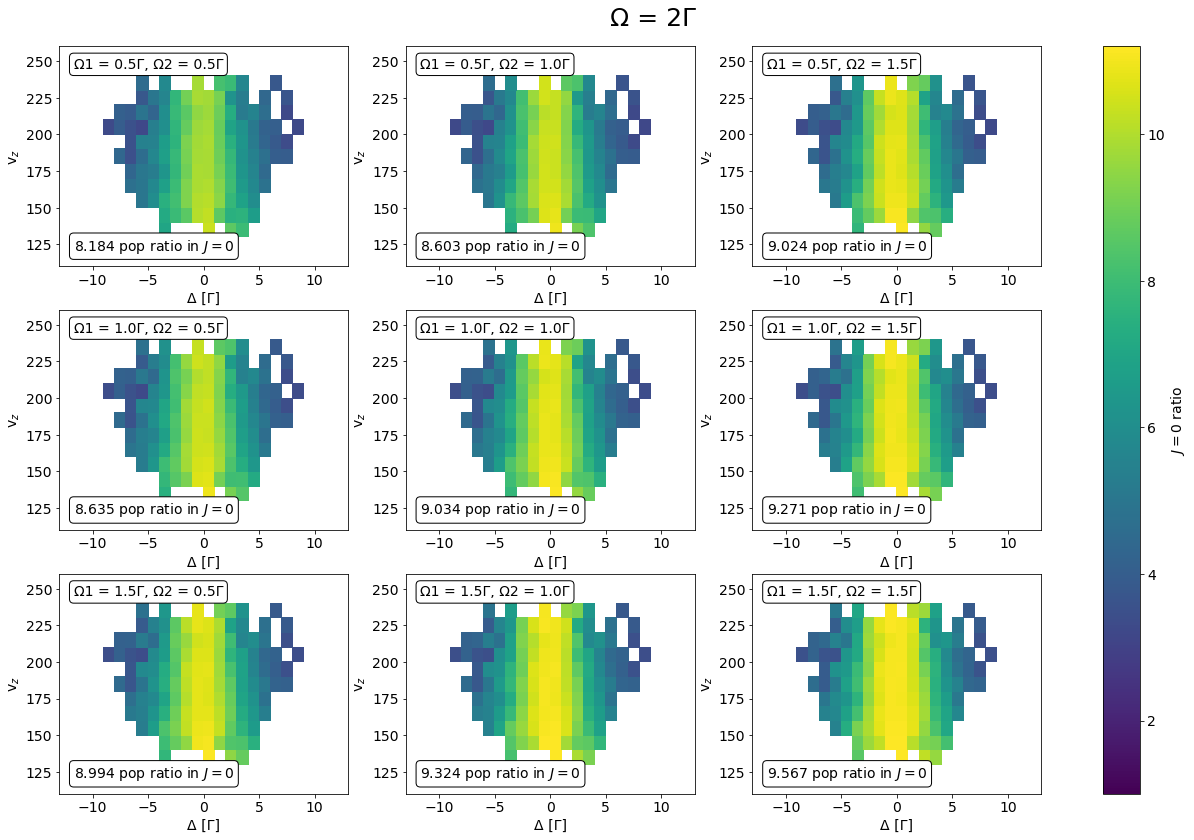

In [155]:
xbins = np.linspace(-13, 13, 27)
ybins = np.linspace(110, 260, 16)

for Ω_factor in np.unique(results_array_J0[:,0]):
    fig, axes = plt.subplots(nrows = 3, ncols = 3, figsize = (22,13.75))
    fig.suptitle(f'Ω = {Ω_factor:.0f}Γ', fontsize = 25, y = 0.92)
    axes = axes.flatten()
    idx = 0
    for idΩ1, Ω1_factor in enumerate(np.unique(results_array_J0[:,1])):
        for idΩ2, Ω2_factor in enumerate(np.unique(results_array_J0[:,2])):
            m = results_array_J0[:,0] == Ω_factor
            m1 = results_array_J0[:,1] == Ω1_factor
            m2 = results_array_J0[:,2] == Ω2_factor
            m = m & m1 & m2

            dat = results_array_J0[m]

            x = dat[:,3]
            y = dat[:,4]
            z = dat[:,-1]
            stat, x_edge, y_edge, bin_number = binned_statistic_2d(x,y,values = z, statistic = 'mean', bins = [xbins, ybins])
            stat /= np.diag(ρ_ini)[:4].sum().real
            X, Y = np.meshgrid(x_edge,y_edge)

            ax = axes[idx]
            cs = ax.pcolormesh(X, Y, stat.T, vmin = 1, vmax = 11.2)

            ax.set_xlabel('Δ [Γ]')
            ax.set_ylabel(r'v$_z$')

            props = dict(boxstyle='round', facecolor='white', alpha=1)
            text = f"Ω1 = {Ω1_factor/Γ:.1f}Γ, Ω2 = {Ω2_factor/Γ:.1f}Γ"
            ax.text(0.05, 0.95, text, transform = ax.transAxes, fontsize = 14, bbox = props,
                    va = 'top', ha = 'left')

            props = dict(boxstyle='round', facecolor='white', alpha=1)
            text = f"{z.mean()/P0_ini:.3f} pop ratio in $J=0$"
            ax.text(0.05, 0.05, text, transform = ax.transAxes, fontsize = 14, bbox = props,
                    va = 'bottom', ha = 'left')

            set_fontsize(ax, 14)
            idx += 1
    
    cbar = fig.colorbar(cs, ax = axes)
    cbar.ax.set_ylabel(r"$J=0$ ratio")
    set_fontsize(cbar.ax, 14)

## Defining a second parameter sweep of Ω, Ω1, Γ and $v_z$, $v_y$ from the distribution
$v_z$, $v_x$, $v_y$ and $y_0$ are coupled from the extended beamsource calculation

In [156]:
# multipass length ~ 1.5"
distance_laser_rc = (21.75-0.75) * in_to_m - 0.01
dt = distance_laser_rc/v_z

y0 = (coords[1,:]+dt*v_y)[mask_filtered_beam]

In [157]:
trajectories = 2000
Main.eval("Omegas = (Ω)*(3:1:4)")
Main.eval("Omegas1 = (Ω1)*(1:1:2)")
Main.eval("Omegas2 = (Ω2)*(1:1:2)")
Main.Deltas = v_x[mask_filtered_beam][:trajectories]*v_to_Γ*Γ
Main.vzs = v_z[mask_filtered_beam][:trajectories]
Main.vys = v_y[mask_filtered_beam][:trajectories]
Main.y0s = y0[:trajectories]

In [158]:
params = np.array(np.meshgrid(Main.Omegas, Main.Omegas1, Main.Omegas2)).T.reshape(-1,3)
_ = np.empty([params.shape[0]*trajectories,7])
_[:,:3] = np.repeat(params, trajectories, axis = 0)
_[:,3:] = np.tile(np.array([Main.Deltas, Main.vzs, Main.vys, Main.y0s]), len(Main.Omegas)*len(Main.Omegas1)*len(Main.Omegas2)).T
params = _
Main.param = params
print(params.shape)

(16000, 7)


In [159]:
# defining a progress bar to keep track of the ODE ensemble solver progress
Main.eval("using ProgressMeter")
Main.eval('const pbar = Progress(50, 1, "ODE Solving ", 50)')

<PyCall.jlwrap Progress(50, ReentrantLock(nothing, Base.GenericCondition{Base.Threads.SpinLock}(Base.InvasiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), 0), 1.0, 0, 1.617147465764e9, 1.617147465764e9, false, "ODE Solving ", 50, BarGlyphs('|', '█', '█', ' ', '|'), :green, Base.TTY(Base.Libc.WindowsRawSocket(0x0000000000000700) open, 0 bytes waiting), 0, 0, 0)>

In [160]:
# function called every time on the when an ODE solve is ready
# only save the diagonal of each solution (e.g. populations in each state)
Main.eval("""
function output_func(sol,i)
    next!(pbar)
    return [real(sol.u[end][j,j]) for j in 1:size(sol.u[end])[1]], false
end""")

<PyCall.jlwrap output_func>

In [161]:
# defining the function that changes the ODE parameters for each iteration
Main.eval("""
function prob_func(prob,i,repeat)
    remake(prob,p=[param[i,1]; νp; param[i,4]; param[i,5]; param[i,6]; param[i,7]; σzlaser; σylaser; n_passes; νp1; muz; muy; σzmu; σymu; param[i,2]; νp2; muz; muy; σzmu; σymu; param[i,3]; amplitudes; beam_locs])
end
""")

<PyCall.jlwrap prob_func>

In [162]:
# setting up the EnsembleProblem with the earlier defined ODEProblem
Main.eval("""
ens_prob = EnsembleProblem(prob, prob_func = prob_func, output_func = output_func)
""")

<PyCall.jlwrap EnsembleProblem with problem ODEProblem>

In [163]:
# making sure multiple threads are enabled
Main.eval("Threads.nthreads()")

10

In [164]:
# starting the parallel ensemble simulation
# precision of the solver is increased resulting in a longer runtime
# probably not necessary
Main.eval("pbar.counter = 0")
Main.eval("pbar.n = size(param)[1]")
Main.eval("""
@time sim = solve(ens_prob, Tsit5(), EnsembleThreads(), save_start = true, save_end = true, 
            save_everystep = false; trajectories = trajectories = size(param)[1], dt = 1e-9, adaptive=true,
            abstol = 5e-7, reltol = 5e-4, callback = cb)
sim.elapsedTime
""")

42952.3718911

In [165]:
ens_u = Main.eval("sim.u")
ens_u = np.array(ens_u)

In [166]:
# putting the results into a single numpy array
results_array = np.zeros([len(ens_u),7+67])

for idx, ((Ω_factor, Ω1_factor, Ω2_factor, Δ_factor, vz_factor, vy_factor, y0_factor), ut_ens) in tqdm(enumerate(zip(Main.param,ens_u)), total = len(ens_u)):
    results_array[idx,:] = [Ω_factor, Ω1_factor, Ω2_factor, Δ_factor, vz_factor, vy_factor, y0_factor] + list(ut_ens)

100%|█████████████████████████████████████████████████████████████████████████| 16000/16000 [00:00<00:00, 56971.18it/s]


In [167]:
fname = 'laser_mu1mu2_rc_pol_switching_on_apertures_2020_10_28_2x_beamheight_2nd'
np.save(fname, results_array)

In [168]:
fname = 'laser_mu1mu2_rc_pol_switching_on_apertures_2020_10_28_2x_beamheight_2nd'
results_array = np.load(fname+'.npy')

In [169]:
# for making Ω slices I round Ω_factor to two digits to preven any floating point issues
# keep in mind when the desired spacing is less than two digits to remove rounding or 
# increase the digits
results_array_J0 = np.zeros([len(results_array),8])
for idx, (Ω_factor, Ω1_factor, Ω2_factor, Δ_factor, vz_factor, vy_factor, y0_factor, *pops) in tqdm(enumerate(results_array), total = len(results_array)):
    results_array_J0[idx,:] = [round(Ω_factor/Γ,2), Ω1_factor, Ω2_factor, Δ_factor/Γ, vz_factor, vy_factor, y0_factor, np.sum(pops[:4])]

100%|█████████████████████████████████████████████████████████████████████████| 16000/16000 [00:00<00:00, 35505.57it/s]


In [170]:
P0_ini = np.diag(ρ_ini[:4,:4]).sum().real

for Ω_factor in np.unique(results_array_J0[:,0]):
    for Ω1_factor in np.unique(results_array_J0[:,1]):
        for Ω2_factor in np.unique(results_array_J0[:,2]):
            m = results_array_J0[:,0] == Ω_factor
            m1 = results_array_J0[:,1] == Ω1_factor
            m2 = results_array_J0[:,2] == Ω2_factor
            m = m & m1 & m2
            mean_population = np.mean(results_array_J0[m][:,-1])/P0_ini
            mean_err_population = np.std(results_array_J0[m][:,-1]/P0_ini)/np.sqrt(trajectories)
            print(f'Ω : {Ω_factor:.1f}Γ; Ω1 : {Ω1_factor/Γ:.1f}Γ; Ω2 : {Ω2_factor/Γ:.1f}Γ  -> ratio = {mean_population:.3f} +/- {mean_err_population:.3f}')

Ω : 3.0Γ; Ω1 : 1.0Γ; Ω2 : 1.0Γ  -> ratio = 10.030 +/- 0.032
Ω : 3.0Γ; Ω1 : 1.0Γ; Ω2 : 2.0Γ  -> ratio = 10.438 +/- 0.028
Ω : 3.0Γ; Ω1 : 2.0Γ; Ω2 : 1.0Γ  -> ratio = 10.427 +/- 0.028
Ω : 3.0Γ; Ω1 : 2.0Γ; Ω2 : 2.0Γ  -> ratio = 10.628 +/- 0.025
Ω : 4.0Γ; Ω1 : 1.0Γ; Ω2 : 1.0Γ  -> ratio = 10.520 +/- 0.022
Ω : 4.0Γ; Ω1 : 1.0Γ; Ω2 : 2.0Γ  -> ratio = 10.826 +/- 0.017
Ω : 4.0Γ; Ω1 : 2.0Γ; Ω2 : 1.0Γ  -> ratio = 10.820 +/- 0.017
Ω : 4.0Γ; Ω1 : 2.0Γ; Ω2 : 2.0Γ  -> ratio = 10.940 +/- 0.014


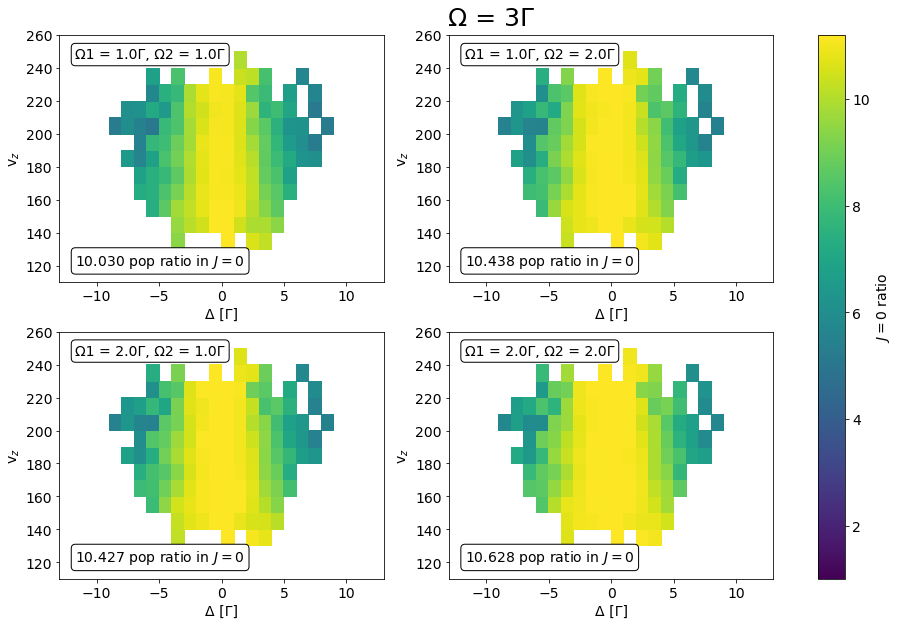

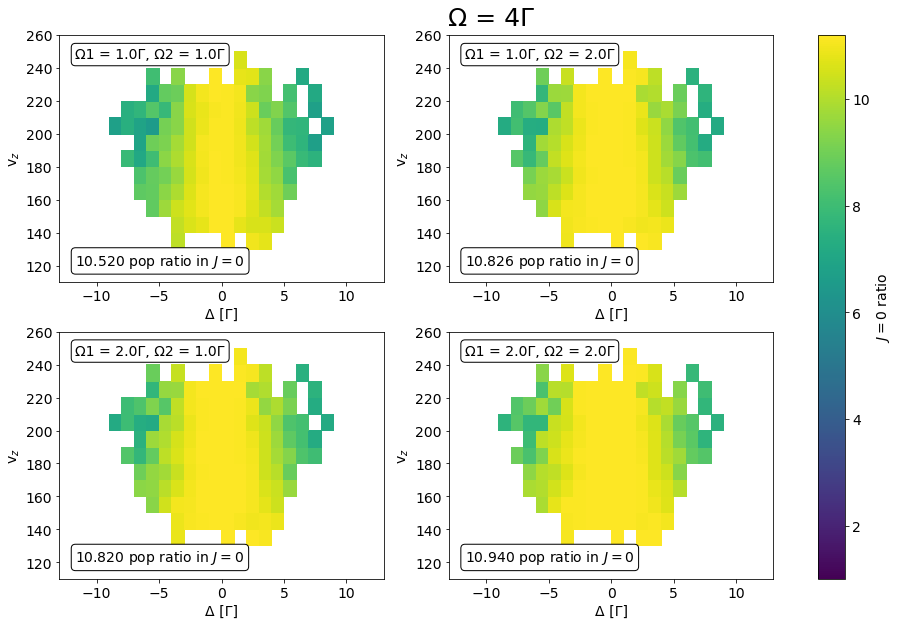

In [172]:
xbins = np.linspace(-13, 13, 27)
ybins = np.linspace(110, 260, 16)

for Ω_factor in np.unique(results_array_J0[:,0]):
    fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (16,10))
    fig.suptitle(f'Ω = {Ω_factor:.0f}Γ', fontsize = 25, y = 0.92)
    axes = axes.flatten()
    idx = 0
    for idΩ1, Ω1_factor in enumerate(np.unique(results_array_J0[:,1])):
        for idΩ2, Ω2_factor in enumerate(np.unique(results_array_J0[:,2])):
            m = results_array_J0[:,0] == Ω_factor
            m1 = results_array_J0[:,1] == Ω1_factor
            m2 = results_array_J0[:,2] == Ω2_factor
            m = m & m1 & m2

            dat = results_array_J0[m]

            x = dat[:,3]
            y = dat[:,4]
            z = dat[:,-1]
            stat, x_edge, y_edge, bin_number = binned_statistic_2d(x,y,values = z, statistic = 'mean', bins = [xbins, ybins])
            stat /= np.diag(ρ_ini)[:4].sum().real
            X, Y = np.meshgrid(x_edge,y_edge)

            ax = axes[idx]
            cs = ax.pcolormesh(X, Y, stat.T, vmin = 1, vmax = 11.2)

            ax.set_xlabel('Δ [Γ]')
            ax.set_ylabel(r'v$_z$')

            props = dict(boxstyle='round', facecolor='white', alpha=1)
            text = f"Ω1 = {Ω1_factor/Γ:.1f}Γ, Ω2 = {Ω2_factor/Γ:.1f}Γ"
            ax.text(0.05, 0.95, text, transform = ax.transAxes, fontsize = 14, bbox = props,
                    va = 'top', ha = 'left')

            props = dict(boxstyle='round', facecolor='white', alpha=1)
            text = f"{z.mean()/P0_ini:.3f} pop ratio in $J=0$"
            ax.text(0.05, 0.05, text, transform = ax.transAxes, fontsize = 14, bbox = props,
                    va = 'bottom', ha = 'left')

            set_fontsize(ax, 14)
            idx += 1
    
    cbar = fig.colorbar(cs, ax = axes)
    cbar.ax.set_ylabel(r"$J=0$ ratio")
    set_fontsize(cbar.ax, 14)